In [1]:
import pandas as pd
from sklearn.linear_model import Ridge, BayesianRidge, ElasticNet, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
import os
import csv
import datetime

# Data Wrangling NHL Data Set

In [2]:
#store skater stats csv into dataframe 
game_skater_df = pd.read_csv("data/game_skater_stats.csv.zip")
player_info_df = pd.read_csv('data/player_info copy.csv')

game_info_df = pd.read_csv('data/game.csv.zip')

#store team info csv into dataframe
team_info_df = pd.read_csv('data/team_info copy.csv')
new_team_df = team_info_df[['team_id', 'shortName']]

#create new dataframe with select columms 
new_game_skater_df = game_skater_df[['game_id', 'player_id', 'team_id', 'timeOnIce', 'assists', 'goals', 'shots', 'blocked', 'powerPlayGoals', 'powerPlayAssists', 'shortHandedGoals', 'shortHandedAssists', ]].copy()
skater_df = new_game_skater_df.drop_duplicates()

#add fantasy points to skater_df
skater_df['fantasy_points'] = (skater_df['assists']*8 + skater_df['goals']*12 + skater_df['shots']*1.6 + skater_df['blocked']*1.6 + skater_df['powerPlayGoals']*0.5 + skater_df['powerPlayAssists']*0.5 + skater_df['shortHandedGoals']*2 + skater_df['shortHandedAssists']*2)
skater_df.fillna(0)
skater_df = skater_df.reset_index(drop=True)

df1 = skater_df.merge(player_info_df, how='left', left_on='player_id', right_on='player_id')
df2 = df1.merge(game_info_df, on='game_id')
df3 = df2.merge(new_team_df, on ='team_id')
df3.head()

df4 = df3[['game_id', 'player_id', 'team_id', 'type', 'season', 'timeOnIce', 'assists', 'goals', 'shots', 'blocked', 'powerPlayGoals', 'powerPlayAssists', 'shortHandedGoals', 'shortHandedAssists', 'fantasy_points', 'shortName','firstName', 'lastName',]]

df5 = df4.sort_values(by='season', ascending = True)

#filter for last 6 regular seasons
filter_list = [20142015, 20152016, 20162017, 20172018, 20182019, 20192020]
filter_type = ['R']

new_skater_df = df5[df5.season.isin(filter_list)]
new_skater_df.reset_index(drop=True, inplace=True)
new_skater_df.head()
final_df = new_skater_df.drop_duplicates()
final_df = final_df[final_df.type.isin(filter_type)]
final_df.head()

,game_id,player_id,team_id,type,season,timeOnIce,assists,goals,shots,blocked,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,fantasy_points,shortName,firstName,lastName
0,2014020382,8476207,29,R,20142015,876,0,0,1,0.0,0,0,0,0,1.6,Columbus,Brian,Gibbons
1,2014020346,8471873,14,R,20142015,1234,1,0,1,0.0,0,0,0,0,9.6,Tampa Bay,Anton,Stralman
2,2014020547,8470230,6,R,20142015,602,0,0,0,0.0,0,0,0,0,0.0,Boston,Daniel,Paille
3,2014020346,8470047,14,R,20142015,1201,0,0,3,0.0,0,0,0,0,4.8,Tampa Bay,Valtteri,Filppula
4,2014020547,8475414,6,R,20142015,589,0,0,1,0.0,0,0,0,0,1.6,Boston,Craig,Cunningham


In [3]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263718 entries, 0 to 375892
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   game_id             263718 non-null  int64  
 1   player_id           263718 non-null  int64  
 2   team_id             263718 non-null  int64  
 3   type                263718 non-null  object 
 4   season              263718 non-null  int64  
 5   timeOnIce           263718 non-null  int64  
 6   assists             263718 non-null  int64  
 7   goals               263718 non-null  int64  
 8   shots               263718 non-null  int64  
 9   blocked             263718 non-null  float64
 10  powerPlayGoals      263718 non-null  int64  
 11  powerPlayAssists    263718 non-null  int64  
 12  shortHandedGoals    263718 non-null  int64  
 13  shortHandedAssists  263718 non-null  int64  
 14  fantasy_points      263718 non-null  float64
 15  shortName           263718 non-nul

In [4]:
filter_2020 = [20192020]
df_2020 =  final_df[final_df.season.isin(filter_2020)]
df_2020 = df_2020[df_2020.type.isin(filter_type)]
df_2020

,game_id,player_id,team_id,type,season,timeOnIce,assists,goals,shots,blocked,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,fantasy_points,shortName,firstName,lastName
288991,2019020621,8477504,52,R,20192020,1355,0,0,1,1.0,0,0,0,0,3.2,Winnipeg,Josh,Morrissey
288992,2019020621,8477359,52,R,20192020,1289,0,0,0,2.0,0,0,0,0,3.2,Winnipeg,Tucker,Poolman
288993,2019020621,8474579,52,R,20192020,1362,0,0,0,4.0,0,0,0,0,6.4,Winnipeg,Luca,Sbisa
288995,2019020621,8479339,52,R,20192020,1037,2,0,2,0.0,0,0,0,0,19.2,Winnipeg,Patrik,Laine
288998,2019020621,8475868,52,R,20192020,960,0,0,2,1.0,0,0,0,0,4.8,Winnipeg,Anthony,Bitetto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375884,2019020479,8471707,22,R,20192020,995,0,0,1,0.0,0,0,0,0,1.6,Edmonton,James,Neal
375887,2019020479,8476915,22,R,20192020,905,0,0,1,1.0,0,0,0,0,3.2,Edmonton,Jujhar,Khaira
375888,2019020479,8476457,22,R,20192020,1018,0,0,1,5.0,0,0,0,0,9.6,Edmonton,Adam,Larsson
375890,2019020479,8476326,22,R,20192020,521,0,0,2,0.0,0,0,0,0,3.2,Edmonton,Josh,Archibald


In [5]:
#goalie stats csv into dataframe
goalie_stats_df = pd.read_csv("data/game_goalie_stats.csv.zip")
goalie_stats_df.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,pim,shots,saves,powerPlaySaves,shortHandedSaves,evenSaves,shortHandedShotsAgainst,evenShotsAgainst,powerPlayShotsAgainst,decision,savePercentage,powerPlaySavePercentage,evenStrengthSavePercentage
0,2016020045,8473607,4,1504,0,0,0,16,12,1,0,11,0,13,3,NaN,75.000000,33.333333,84.615385
1,2016020045,8473461,4,2011,0,0,0,11,9,1,0,8,0,10,1,L,81.818182,100.000000,80.000000
2,2016020045,8470645,16,3598,0,0,0,27,23,2,0,21,0,23,4,W,85.185185,50.000000,91.304348
3,2017020812,8468011,24,3696,0,0,0,33,30,1,2,27,3,28,2,W,90.909091,50.000000,96.428571
4,2017020812,8475215,7,3539,0,0,0,33,29,4,1,24,1,27,5,L,87.878788,80.000000,88.888889


In [6]:
## select goalie stats df
new_goalie_df = goalie_stats_df[['game_id', 'player_id', 'team_id', 'timeOnIce', 'assists', 'goals', 'shots', 'saves', 'savePercentage','decision']]

#add goals against column
new_goalie_df['goals_against'] = new_goalie_df['shots'] - new_goalie_df['saves']
goalie_df1 = new_goalie_df.drop_duplicates()
goalie_df = goalie_df1.fillna(0)

#add shutout and win columns
goalie_df['shutout'] = np.where((goalie_df['goals_against'] == 0) & (goalie_df['decision']!= 0), 1, 0)
goalie_df['win'] = np.where((goalie_df['decision']== 'W'), 1, 0)


#add fantasy points column to goalie df
goalie_df['fantasy_points'] = (goalie_df['goals']*12 + goalie_df['assists']*8 + goalie_df['saves']*0.8 + goalie_df['shutout']*8 + goalie_df['goals_against']*-4 + goalie_df['win']*12)
goalie_df

df_1 = goalie_df.merge(player_info_df, how='left', left_on='player_id', right_on='player_id')
df_2 = df_1.merge(game_info_df, on='game_id')
df_3 = df_2.merge(new_team_df, on ='team_id')
df_3.head()

df_4 = df_3[['game_id', 'player_id', 'team_id', 'type', 'season', 'timeOnIce', 'goals', 'assists', 'shots', 'saves', 'savePercentage', 'decision', 'shutout', 'goals_against', 'fantasy_points', 'shortName','firstName', 'lastName']]

df_5 = df_4.sort_values(by='season', ascending = True)

#filter for last 6 seasons
filter_list = [20142015, 20152016, 20162017, 20172018, 20182019, 20192020]
filter_type = ['R']

goalie_df = df_5[df_5.season.isin(filter_list)]
goalie_df.reset_index(drop=True, inplace=True)
goalie_df.head()
new_goalie_df = goalie_df[goalie_df.type.isin(filter_type)]
new_goalie_df.head()

,game_id,player_id,team_id,type,season,timeOnIce,goals,assists,shots,saves,savePercentage,decision,shutout,goals_against,fantasy_points,shortName,firstName,lastName
0,2014020686,8475622,18,R,20142015,3846,0,0,27,25,92.592593,L,0,2,12.0,Nashville,Carter,Hutton
1,2014020207,8473461,4,R,20142015,3600,0,0,39,36,92.307692,W,0,3,28.8,Philadelphia,Steve,Mason
2,2014020602,8471469,18,R,20142015,3615,0,0,20,18,90.000000,W,0,2,18.4,Nashville,Pekka,Rinne
3,2014020466,8470140,25,R,20142015,3589,0,0,27,27,100.000000,W,1,0,41.6,Dallas,Kari,Lehtonen
4,2014020303,8470140,25,R,20142015,3600,0,1,41,37,90.243902,W,0,4,33.6,Dallas,Kari,Lehtonen


In [7]:
filter_2020 = [20192020]
df_goalie_2020 =  new_goalie_df[new_goalie_df.season.isin(filter_2020)]
df_goalie_2020 = df_goalie_2020[df_goalie_2020.type.isin(filter_type)]
df_goalie_2020

,game_id,player_id,team_id,type,season,timeOnIce,goals,assists,shots,saves,savePercentage,decision,shutout,goals_against,fantasy_points,shortName,firstName,lastName
17267,2019020038,8476945,52,R,20192020,3600,0,0,38,37,97.368421,W,0,1,37.6,Winnipeg,Connor,Hellebuyck
17268,2019020989,8471774,30,R,20192020,3565,0,0,26,25,96.153846,W,0,1,28.0,Minnesota,Alex,Stalock
17269,2019020978,8471774,30,R,20192020,3600,0,0,28,24,85.714286,W,0,4,15.2,Minnesota,Alex,Stalock
17270,2019020978,8471774,30,R,20192020,3600,0,0,28,24,85.714286,W,0,4,15.2,Minnesota,Alex,Stalock
17271,2019020038,8476945,52,R,20192020,3600,0,0,38,37,97.368421,W,0,1,37.6,Winnipeg,Connor,Hellebuyck
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22417,2019020003,8469608,22,R,20192020,3600,0,0,33,31,93.939394,W,0,2,28.8,Edmonton,Mike,Smith
22418,2019020003,8469608,22,R,20192020,3600,0,0,33,31,93.939394,W,0,2,28.8,Edmonton,Mike,Smith
22419,2019021072,8478406,1,R,20192020,3572,0,0,32,28,87.500000,L,0,4,6.4,New Jersey,Mackenzie,Blackwood
22420,2019021055,8478406,1,R,20192020,3600,0,0,35,31,88.571429,W,0,4,20.8,New Jersey,Mackenzie,Blackwood


In [8]:
#store player info csv into dataframe 
player_info_df = pd.read_csv('data/player_info copy.csv')
player_info_df.head()

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R


In [9]:
#store team info csv into dataframe
team_info_df = pd.read_csv('data/team_info copy.csv')
new_team_df = team_info_df[['team_id', 'shortName']]
new_team_df.head(5)

,team_id,shortName
0,1,New Jersey
1,4,Philadelphia
2,26,Los Angeles
3,14,Tampa Bay
4,6,Boston


In [10]:
#create new dataframe with select columms
new_player_info_df = player_info_df [['player_id', 'firstName', 'lastName', 'nationality']].copy()
new_player_info_df.head()


,player_id,firstName,lastName,nationality
0,8466148,Marian,Hossa,SVK
1,8465058,Michal,Rozsival,CZE
2,8476906,Shayne,Gostisbehere,USA
3,8466285,Brian,Campbell,CAN
4,8470607,Brent,Seabrook,CAN


In [11]:
# store game info csv into a dataframe
game_info_df = pd.read_csv('data/game.csv.zip')


In [12]:
# creat new dataframe with select columns
new_game_info_df = game_info_df [['game_id', 'season', 'date_time_GMT', 'home_team_id', 'home_goals', 'outcome']].copy()
new_game_info_df.head()

,game_id,season,date_time_GMT,home_team_id,home_goals,outcome
0,2016020045,20162017,2016-10-19T00:30:00Z,16,7,home win REG
1,2017020812,20172018,2018-02-07T00:00:00Z,7,3,away win OT
2,2015020314,20152016,2015-11-24T01:00:00Z,52,1,away win REG
3,2015020849,20152016,2016-02-17T00:00:00Z,12,2,home win REG
4,2017020586,20172018,2017-12-30T03:00:00Z,24,2,home win REG


In [13]:
# cleaning new game info dataframe
cleaned_game_info = new_game_info_df[~new_game_info_df['season'].isin(['20142015', '20152016','20162017','20172018','20182019','20192020'])]
cleaned_game_info.head()

,game_id,season,date_time_GMT,home_team_id,home_goals,outcome
4961,2013020674,20132014,2014-01-11T03:00:00Z,23,2,home win REG
4962,2013020177,20132014,2013-10-29T23:00:00Z,4,2,away win REG
4963,2012020225,20122013,2013-02-19T03:00:00Z,24,3,home win REG
4964,2012020577,20122013,2013-04-08T23:00:00Z,6,6,home win REG
4965,2013021085,20132014,2014-03-25T23:30:00Z,29,4,home win REG


In [14]:
# RC
# The effect of the previous cell is that only seasons prior to 2014 are included in the clean_game_info dataframe.
cleaned_game_info["season"].unique()

array([20132014, 20122013, 20112012, 20102011, 20092010, 20082009,
       20072008, 20062007, 20022003, 20032004, 20052006, 20002001,
       20012002], dtype=int64)

# Data Analysis of Previous NHL Seasons Data

In [15]:
#Top fantasy points scorers last 6 seasons


top_df = final_df.reset_index().groupby("player_id").sum()
top_df = top_df[['team_id', 'timeOnIce', 'assists', 'goals', 'shots', 'blocked', 'powerPlayGoals', 'powerPlayAssists', 'shortHandedGoals', 'shortHandedAssists', 'fantasy_points']]
top_df = top_df.sort_values(by=['fantasy_points'], ascending=False)

df = top_df.merge(new_player_info_df, how='left', left_on='player_id', right_on='player_id').sort_values(by=['fantasy_points'], ascending=False)
df.head(50)

# Top 25 skaters 14/15-19/20 seasons
top = df[['firstName', 'lastName','fantasy_points']]
top.head(25)




,firstName,lastName,fantasy_points
0,Alex,Ovechkin,8619.7
1,Patrick,Kane,7981.7
2,Brent,Burns,7862.7
3,Nikita,Kucherov,7643.3
4,Tyler,Seguin,7430.5
5,John,Tavares,7320.2
6,Nathan,MacKinnon,7230.3
7,Sidney,Crosby,7194.8
8,Blake,Wheeler,7157.7
9,Brad,Marchand,6861.1


In [16]:
# Top 25 skaters from previous 19/20 season 

top_2020 = df_2020.reset_index().groupby("player_id").sum()
top_2020 = top_2020[['team_id', 'timeOnIce', 'assists', 'goals', 'shots', 'blocked', 'powerPlayGoals', 'powerPlayAssists', 'shortHandedGoals', 'shortHandedAssists', 'fantasy_points']]
top_2020 = top_2020.sort_values(by=['fantasy_points'], ascending=False)

top_2020_df = top_2020.merge(new_player_info_df, how='left', left_on='player_id', right_on='player_id').sort_values(by=['fantasy_points'], ascending=False)


# Top 25 skaters 14/15-19/20 seasons
top_2020_df = top_2020_df[['firstName', 'lastName','fantasy_points']]
top_2020_df.head(25)

,firstName,lastName,fantasy_points
0,Nathan,MacKinnon,1510.9
1,David,Pastrnak,1475.0
2,Leon,Draisaitl,1453.2
3,Auston,Matthews,1400.5
4,Connor,McDavid,1301.5
5,Alex,Ovechkin,1298.6
6,Patrick,Kane,1285.9
7,Artemi,Panarin,1263.2
8,Nikita,Kucherov,1228.5
9,Jack,Eichel,1213.9


In [17]:
#Top fantasy points goalies last 6 seasons
#'game_id', 'player_id', 'team_id', 'type', 'season', 'timeOnIce', 'goals', 'assists', 'shots', 'saves', 'savePercentage', 'decision', 'shutout', 'goals_against', 'fantasy_points', 'shortName','firstName', 'lastName'

top_goalie_df = new_goalie_df.reset_index().groupby("player_id").sum()
top_goalie_df.head(5)
#top_goalie_df = top_goalie_df[['team_id', 'timeOnIce', 'assists', 'goals', 'shots', 'saves', 'savePercentage', 'decision', 'shutout', 'goals_against', 'fantasy_points', 'shortName', 'firstName', 'LastName']]
top_goalie_df = top_goalie_df.sort_values(by=['fantasy_points'], ascending=False)

goalie_df = top_goalie_df.merge(new_player_info_df, how='left', left_on='player_id', right_on='player_id').sort_values(by=['fantasy_points'], ascending=False)
df.head(50)

# Top 25 goalies 14/15-19/20 seasons
top_goalie = goalie_df[['firstName', 'lastName','fantasy_points']]
top_goalie.head(25)


,firstName,lastName,fantasy_points
0,Braden,Holtby,8908.0
1,Frederik,Andersen,8802.4
2,Sergei,Bobrovsky,8296.8
3,Carey,Price,8268.8
4,Tuukka,Rask,8214.4
5,Marc-Andre,Fleury,8149.6
6,Pekka,Rinne,8099.2
7,Devan,Dubnyk,7971.2
8,Andrei,Vasilevskiy,7965.6
9,Ben,Bishop,7712.0


In [18]:
# Top 25 goalies from previous 19/20 season 

top_goalie_2020 = df_goalie_2020.reset_index().groupby("player_id").sum()
#top_goalie_2020 = top_goalie_2020[['team_id', 'timeOnIce', 'assists', 'goals', 'shots', 'saves', 'savePercentage', 'decision', 'shutout', 'goals_against', 'fantasy_points', 'shortName', 'firstName', 'LastName']]
top_goalie_2020 = top_goalie_2020.sort_values(by=['fantasy_points'], ascending=False)

top_goalie_2020_df = top_goalie_2020.merge(new_player_info_df, how='left', left_on='player_id', right_on='player_id').sort_values(by=['fantasy_points'], ascending=False)


# Top 25 goalies 14/15-19/20 seasons
top_goalie_2020_df = top_goalie_2020_df[['firstName', 'lastName','fantasy_points']]
top_goalie_2020_df.head(25)

,firstName,lastName,fantasy_points
0,Connor,Hellebuyck,2417.6
1,Andrei,Vasilevskiy,2366.4
2,Carey,Price,1984.0
3,Jordan,Binnington,1907.2
4,Frederik,Andersen,1894.4
5,Tuukka,Rask,1870.4
6,Jacob,Markstrom,1748.8
7,Mackenzie,Blackwood,1724.8
8,Marc-Andre,Fleury,1702.4
9,David,Rittich,1664.0


# Machine Learning Models 



## Linear Regression

In [19]:
def clean_dataset(skater_df):
    assert isinstance(df, skater_df.DataFrame), "df needs to be a pd.DataFrame"
    skater_df.dropna(inplace=True)
    indices_to_keep = ~skater_df.isin([np.nan, np.inf, -np.inf]).any(1)
    return skater_df[indices_to_keep].astype(np.float64)

In [20]:
pd.isnull(skater_df).sum() > 0

game_id               False
player_id             False
team_id               False
timeOnIce             False
assists               False
goals                 False
shots                 False
blocked                True
powerPlayGoals        False
powerPlayAssists      False
shortHandedGoals      False
shortHandedAssists    False
fantasy_points         True
dtype: bool

In [21]:
skater_df = skater_df.dropna(how='any',axis=0)

In [22]:

x = skater_df['timeOnIce'].values.reshape(-1,1)
y = skater_df['fantasy_points'].values.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
regressor = LinearRegression()

#training the algorithm
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

model_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted' : y_pred.flatten()})
model_df.head()

,Actual,Predicted
0,3.2,10.967906
1,3.2,11.917271
2,6.4,9.969856
3,1.6,10.862421
4,4.8,8.906892


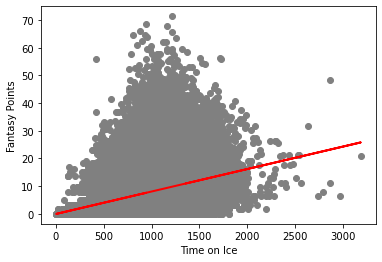

In [23]:
plt.scatter(x_test, y_test, color='gray')
plt.plot(x_test, y_pred, color='red', linewidth=2)
plt.xlabel('Time on Ice')
plt.ylabel('Fantasy Points')
plt.show()

In [24]:
def clean_dataset(goalie_df):
    assert isinstance(df, goalie_df.DataFrame), "df needs to be a pd.DataFrame"
    goalie_df.dropna(inplace=True)
    indices_to_keep = ~goalie_df.isin([np.nan, np.inf, -np.inf]).any(1)
    return goalie_df[indices_to_keep].astype(np.float64)

In [25]:
pd.isnull(goalie_df).sum() > 0

player_id         False
index             False
game_id           False
team_id           False
season            False
timeOnIce         False
goals             False
assists           False
shots             False
saves             False
savePercentage    False
shutout           False
goals_against     False
fantasy_points    False
firstName         False
lastName          False
nationality        True
dtype: bool

In [26]:
goalie_df = goalie_df.dropna(how='any',axis=0)

In [27]:
x = goalie_df['timeOnIce'].values.reshape(-1,1)
y = goalie_df['fantasy_points'].values.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
regressor = LinearRegression()

#training the algorithm
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

model_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted' : y_pred.flatten()})
model_df.head()

,Actual,Predicted
0,9.6,-73.546269
1,2539.2,2387.251755
2,100.8,85.996429
3,2016.8,2271.786763
4,336.0,331.662513


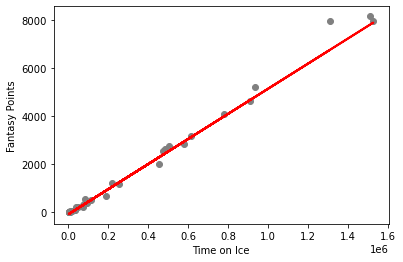

In [28]:
plt.scatter(x_test, y_test, color='gray')
plt.plot(x_test, y_pred, color='red', linewidth=2)
plt.xlabel('Time on Ice')
plt.ylabel('Fantasy Points')
plt.show()

# XGBoost Model

## Format Data - Split Data into Dependent and Independent Variables 

In [29]:
# X - data we will use to make classifactions and predict y

X = final_df.drop('fantasy_points', axis=1).copy()
X.head()

,game_id,player_id,team_id,type,season,timeOnIce,assists,goals,shots,blocked,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,shortName,firstName,lastName
0,2014020382,8476207,29,R,20142015,876,0,0,1,0.0,0,0,0,0,Columbus,Brian,Gibbons
1,2014020346,8471873,14,R,20142015,1234,1,0,1,0.0,0,0,0,0,Tampa Bay,Anton,Stralman
2,2014020547,8470230,6,R,20142015,602,0,0,0,0.0,0,0,0,0,Boston,Daniel,Paille
3,2014020346,8470047,14,R,20142015,1201,0,0,3,0.0,0,0,0,0,Tampa Bay,Valtteri,Filppula
4,2014020547,8475414,6,R,20142015,589,0,0,1,0.0,0,0,0,0,Boston,Craig,Cunningham


In [30]:
X.dtypes


game_id                 int64
player_id               int64
team_id                 int64
type                   object
season                  int64
timeOnIce               int64
assists                 int64
goals                   int64
shots                   int64
blocked               float64
powerPlayGoals          int64
powerPlayAssists        int64
shortHandedGoals        int64
shortHandedAssists      int64
shortName              object
firstName              object
lastName               object
dtype: object

### One-Hot Encoding 

In [31]:
# we need to encode all categorical values into continuous data 

X_encoded = pd.get_dummies(X, columns=['type',
                                       'shortName',
                                       'firstName',
                                       'lastName'])
X_encoded.head()

,game_id,player_id,team_id,season,timeOnIce,assists,goals,shots,blocked,powerPlayGoals,...,lastName_Zibanejad,lastName_Zidlicky,lastName_Zolnierczyk,lastName_Zubrus,lastName_Zuccarello,lastName_Zucker,lastName_Zykov,lastName_de Haan,lastName_de la Rose,lastName_van Riemsdyk
0,2014020382,8476207,29,20142015,876,0,0,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014020346,8471873,14,20142015,1234,1,0,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014020547,8470230,6,20142015,602,0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,2014020346,8470047,14,20142015,1201,0,0,3,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,2014020547,8475414,6,20142015,589,0,0,1,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
y = final_df['fantasy_points'].copy()
y.head()

0    1.6
1    9.6
2    0.0
3    4.8
4    1.6
Name: fantasy_points, dtype: float64

In [33]:
# RC
df_2020

,game_id,player_id,team_id,type,season,timeOnIce,assists,goals,shots,blocked,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,fantasy_points,shortName,firstName,lastName
288991,2019020621,8477504,52,R,20192020,1355,0,0,1,1.0,0,0,0,0,3.2,Winnipeg,Josh,Morrissey
288992,2019020621,8477359,52,R,20192020,1289,0,0,0,2.0,0,0,0,0,3.2,Winnipeg,Tucker,Poolman
288993,2019020621,8474579,52,R,20192020,1362,0,0,0,4.0,0,0,0,0,6.4,Winnipeg,Luca,Sbisa
288995,2019020621,8479339,52,R,20192020,1037,2,0,2,0.0,0,0,0,0,19.2,Winnipeg,Patrik,Laine
288998,2019020621,8475868,52,R,20192020,960,0,0,2,1.0,0,0,0,0,4.8,Winnipeg,Anthony,Bitetto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375884,2019020479,8471707,22,R,20192020,995,0,0,1,0.0,0,0,0,0,1.6,Edmonton,James,Neal
375887,2019020479,8476915,22,R,20192020,905,0,0,1,1.0,0,0,0,0,3.2,Edmonton,Jujhar,Khaira
375888,2019020479,8476457,22,R,20192020,1018,0,0,1,5.0,0,0,0,0,9.6,Edmonton,Adam,Larsson
375890,2019020479,8476326,22,R,20192020,521,0,0,2,0.0,0,0,0,0,3.2,Edmonton,Josh,Archibald


In [34]:
# RC
df_2020_gp = df_2020

In [35]:
# RC
df_2020_gp["gp"] = np.where((df_2020["timeOnIce"] > 0), 1, 0)
df_2020_gp

,game_id,player_id,team_id,type,season,timeOnIce,assists,goals,shots,blocked,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,fantasy_points,shortName,firstName,lastName,gp
288991,2019020621,8477504,52,R,20192020,1355,0,0,1,1.0,0,0,0,0,3.2,Winnipeg,Josh,Morrissey,1
288992,2019020621,8477359,52,R,20192020,1289,0,0,0,2.0,0,0,0,0,3.2,Winnipeg,Tucker,Poolman,1
288993,2019020621,8474579,52,R,20192020,1362,0,0,0,4.0,0,0,0,0,6.4,Winnipeg,Luca,Sbisa,1
288995,2019020621,8479339,52,R,20192020,1037,2,0,2,0.0,0,0,0,0,19.2,Winnipeg,Patrik,Laine,1
288998,2019020621,8475868,52,R,20192020,960,0,0,2,1.0,0,0,0,0,4.8,Winnipeg,Anthony,Bitetto,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375884,2019020479,8471707,22,R,20192020,995,0,0,1,0.0,0,0,0,0,1.6,Edmonton,James,Neal,1
375887,2019020479,8476915,22,R,20192020,905,0,0,1,1.0,0,0,0,0,3.2,Edmonton,Jujhar,Khaira,1
375888,2019020479,8476457,22,R,20192020,1018,0,0,1,5.0,0,0,0,0,9.6,Edmonton,Adam,Larsson,1
375890,2019020479,8476326,22,R,20192020,521,0,0,2,0.0,0,0,0,0,3.2,Edmonton,Josh,Archibald,1


In [36]:
# RC
team_info_df

,team_id,franchiseId,shortName,teamName,abbreviation,link
0,1,23,New Jersey,Devils,NJD,/api/v1/teams/1
1,4,16,Philadelphia,Flyers,PHI,/api/v1/teams/4
2,26,14,Los Angeles,Kings,LAK,/api/v1/teams/26
3,14,31,Tampa Bay,Lightning,TBL,/api/v1/teams/14
4,6,6,Boston,Bruins,BOS,/api/v1/teams/6
5,3,10,NY Rangers,Rangers,NYR,/api/v1/teams/3
6,5,17,Pittsburgh,Penguins,PIT,/api/v1/teams/5
7,17,12,Detroit,Red Wings,DET,/api/v1/teams/17
8,28,29,San Jose,Sharks,SJS,/api/v1/teams/28
9,18,34,Nashville,Predators,NSH,/api/v1/teams/18


In [37]:
# RC
player_info_df

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...
3920,8479374,Adam,Mascherin,CAN,Maple,LW,1998-06-06 01:00:00,ON,"5' 10""",177.80,205.0,L
3921,8479403,Tyler,Parsons,USA,Mt. Clemas,G,1997-09-18 01:00:00,MI,"6' 1""",185.42,185.0,L
3922,8480970,Marcus,Hogstrom,SWE,Sveg,D,1989-03-20 00:00:00,NaN,"6' 4""",193.04,200.0,L
3923,8477574,Parker,Milner,USA,Pittsburgh,G,1990-09-06 01:00:00,PA,"6' 1""",185.42,185.0,L


In [38]:
# RC
player_info_df.dtypes

player_id               int64
firstName              object
lastName               object
nationality            object
birthCity              object
primaryPosition        object
birthDate              object
birthStateProvince     object
height                 object
height_cm             float64
weight                float64
shootsCatches          object
dtype: object

In [39]:
# RC 
player_info_df["BirthYear"] = pd.DatetimeIndex(player_info_df["birthDate"]).year
player_info_df

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches,BirthYear
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L,1979
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R,1978
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L,1993
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L,1979
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R,1985
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3920,8479374,Adam,Mascherin,CAN,Maple,LW,1998-06-06 01:00:00,ON,"5' 10""",177.80,205.0,L,1998
3921,8479403,Tyler,Parsons,USA,Mt. Clemas,G,1997-09-18 01:00:00,MI,"6' 1""",185.42,185.0,L,1997
3922,8480970,Marcus,Hogstrom,SWE,Sveg,D,1989-03-20 00:00:00,NaN,"6' 4""",193.04,200.0,L,1989
3923,8477574,Parker,Milner,USA,Pittsburgh,G,1990-09-06 01:00:00,PA,"6' 1""",185.42,185.0,L,1990


In [40]:
#RC 
player_info_df.dtypes

player_id               int64
firstName              object
lastName               object
nationality            object
birthCity              object
primaryPosition        object
birthDate              object
birthStateProvince     object
height                 object
height_cm             float64
weight                float64
shootsCatches          object
BirthYear               int64
dtype: object

In [41]:
# RC
skaters_2020_merged_player_info = df_2020_gp.merge(player_info_df, how='left', left_on='player_id', right_on='player_id')
skaters_2020_merged_player_info

,game_id,player_id,team_id,type,season,timeOnIce,assists,goals,shots,blocked,...,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches,BirthYear
0,2019020621,8477504,52,R,20192020,1355,0,0,1,1.0,...,CAN,Calgary,D,1995-03-28 01:00:00,AB,"6' 0""",182.88,195.0,L,1995
1,2019020621,8477359,52,R,20192020,1289,0,0,0,2.0,...,USA,Dubuque,D,1993-06-08 01:00:00,IA,"6' 2""",187.96,199.0,R,1993
2,2019020621,8474579,52,R,20192020,1362,0,0,0,4.0,...,CHE,Ozieri,D,1990-01-30 00:00:00,NaN,"6' 2""",187.96,209.0,L,1990
3,2019020621,8479339,52,R,20192020,1037,2,0,2,0.0,...,FIN,Tampere,RW,1998-04-19 01:00:00,NaN,"6' 5""",195.58,206.0,R,1998
4,2019020621,8475868,52,R,20192020,960,0,0,2,1.0,...,USA,Island Park,D,1990-07-15 01:00:00,NY,"6' 1""",185.42,210.0,L,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39376,2019020479,8471707,22,R,20192020,995,0,0,1,0.0,...,CAN,Whitby,LW,1987-09-03 01:00:00,ON,"6' 2""",187.96,221.0,L,1987
39377,2019020479,8476915,22,R,20192020,905,0,0,1,1.0,...,CAN,Surrey,LW,1994-08-13 01:00:00,BC,"6' 4""",193.04,214.0,L,1994
39378,2019020479,8476457,22,R,20192020,1018,0,0,1,5.0,...,SWE,Skellefteå,D,1992-11-12 00:00:00,NaN,"6' 3""",190.50,210.0,R,1992
39379,2019020479,8476326,22,R,20192020,521,0,0,2,0.0,...,CAN,Regina,RW,1992-10-06 01:00:00,SK,"5' 10""",177.80,176.0,R,1992


In [42]:
# RC
skaters_2020_merged_player_info.dtypes

game_id                 int64
player_id               int64
team_id                 int64
type                   object
season                  int64
timeOnIce               int64
assists                 int64
goals                   int64
shots                   int64
blocked               float64
powerPlayGoals          int64
powerPlayAssists        int64
shortHandedGoals        int64
shortHandedAssists      int64
fantasy_points        float64
shortName              object
firstName_x            object
lastName_x             object
gp                      int32
firstName_y            object
lastName_y             object
nationality            object
birthCity              object
primaryPosition        object
birthDate              object
birthStateProvince     object
height                 object
height_cm             float64
weight                float64
shootsCatches          object
BirthYear               int64
dtype: object

In [43]:
# RC
skaters_2020_merged_player_info["currentyear"] = skaters_2020_merged_player_info["season"].astype(str).str[:4].astype(int)
skaters_2020_merged_player_info

,game_id,player_id,team_id,type,season,timeOnIce,assists,goals,shots,blocked,...,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches,BirthYear,currentyear
0,2019020621,8477504,52,R,20192020,1355,0,0,1,1.0,...,Calgary,D,1995-03-28 01:00:00,AB,"6' 0""",182.88,195.0,L,1995,2019
1,2019020621,8477359,52,R,20192020,1289,0,0,0,2.0,...,Dubuque,D,1993-06-08 01:00:00,IA,"6' 2""",187.96,199.0,R,1993,2019
2,2019020621,8474579,52,R,20192020,1362,0,0,0,4.0,...,Ozieri,D,1990-01-30 00:00:00,NaN,"6' 2""",187.96,209.0,L,1990,2019
3,2019020621,8479339,52,R,20192020,1037,2,0,2,0.0,...,Tampere,RW,1998-04-19 01:00:00,NaN,"6' 5""",195.58,206.0,R,1998,2019
4,2019020621,8475868,52,R,20192020,960,0,0,2,1.0,...,Island Park,D,1990-07-15 01:00:00,NY,"6' 1""",185.42,210.0,L,1990,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39376,2019020479,8471707,22,R,20192020,995,0,0,1,0.0,...,Whitby,LW,1987-09-03 01:00:00,ON,"6' 2""",187.96,221.0,L,1987,2019
39377,2019020479,8476915,22,R,20192020,905,0,0,1,1.0,...,Surrey,LW,1994-08-13 01:00:00,BC,"6' 4""",193.04,214.0,L,1994,2019
39378,2019020479,8476457,22,R,20192020,1018,0,0,1,5.0,...,Skellefteå,D,1992-11-12 00:00:00,NaN,"6' 3""",190.50,210.0,R,1992,2019
39379,2019020479,8476326,22,R,20192020,521,0,0,2,0.0,...,Regina,RW,1992-10-06 01:00:00,SK,"5' 10""",177.80,176.0,R,1992,2019


In [44]:
# RC
skaters_2020_merged_player_info["age"] = skaters_2020_merged_player_info["currentyear"] - skaters_2020_merged_player_info["BirthYear"]
skaters_2020_merged_player_info

,game_id,player_id,team_id,type,season,timeOnIce,assists,goals,shots,blocked,...,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches,BirthYear,currentyear,age
0,2019020621,8477504,52,R,20192020,1355,0,0,1,1.0,...,D,1995-03-28 01:00:00,AB,"6' 0""",182.88,195.0,L,1995,2019,24
1,2019020621,8477359,52,R,20192020,1289,0,0,0,2.0,...,D,1993-06-08 01:00:00,IA,"6' 2""",187.96,199.0,R,1993,2019,26
2,2019020621,8474579,52,R,20192020,1362,0,0,0,4.0,...,D,1990-01-30 00:00:00,NaN,"6' 2""",187.96,209.0,L,1990,2019,29
3,2019020621,8479339,52,R,20192020,1037,2,0,2,0.0,...,RW,1998-04-19 01:00:00,NaN,"6' 5""",195.58,206.0,R,1998,2019,21
4,2019020621,8475868,52,R,20192020,960,0,0,2,1.0,...,D,1990-07-15 01:00:00,NY,"6' 1""",185.42,210.0,L,1990,2019,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39376,2019020479,8471707,22,R,20192020,995,0,0,1,0.0,...,LW,1987-09-03 01:00:00,ON,"6' 2""",187.96,221.0,L,1987,2019,32
39377,2019020479,8476915,22,R,20192020,905,0,0,1,1.0,...,LW,1994-08-13 01:00:00,BC,"6' 4""",193.04,214.0,L,1994,2019,25
39378,2019020479,8476457,22,R,20192020,1018,0,0,1,5.0,...,D,1992-11-12 00:00:00,NaN,"6' 3""",190.50,210.0,R,1992,2019,27
39379,2019020479,8476326,22,R,20192020,521,0,0,2,0.0,...,RW,1992-10-06 01:00:00,SK,"5' 10""",177.80,176.0,R,1992,2019,27


In [45]:
# RC
skaters_2020_merged_player_info["season"].unique()

array([20192020], dtype=int64)

In [46]:
# RC
skaters_2020_merged_player_info["season"].value_counts()

20192020    39381
Name: season, dtype: int64

In [47]:
# RC
skaters_2020_merged_player_info["team_id"].value_counts()

54    1332
19    1332
21    1314
14    1314
6     1313
25    1296
15    1296
4     1296
17    1278
52    1278
8     1278
22    1278
24    1278
9     1277
53    1260
3     1260
29    1260
26    1260
28    1260
10    1260
20    1260
16    1259
7     1242
5     1242
30    1242
13    1242
18    1242
23    1242
1     1242
12    1224
2     1224
Name: team_id, dtype: int64

In [48]:
# RC
skaters_2020_merged_player_team_info = skaters_2020_merged_player_info.merge(team_info_df, on ='team_id')
skaters_2020_merged_player_team_info

,game_id,player_id,team_id,type,season,timeOnIce,assists,goals,shots,blocked,...,weight,shootsCatches,BirthYear,currentyear,age,franchiseId,shortName_y,teamName,abbreviation,link
0,2019020621,8477504,52,R,20192020,1355,0,0,1,1.0,...,195.0,L,1995,2019,24,35,Winnipeg,Jets,WPG,/api/v1/teams/52
1,2019020621,8477359,52,R,20192020,1289,0,0,0,2.0,...,199.0,R,1993,2019,26,35,Winnipeg,Jets,WPG,/api/v1/teams/52
2,2019020621,8474579,52,R,20192020,1362,0,0,0,4.0,...,209.0,L,1990,2019,29,35,Winnipeg,Jets,WPG,/api/v1/teams/52
3,2019020621,8479339,52,R,20192020,1037,2,0,2,0.0,...,206.0,R,1998,2019,21,35,Winnipeg,Jets,WPG,/api/v1/teams/52
4,2019020621,8475868,52,R,20192020,960,0,0,2,1.0,...,210.0,L,1990,2019,29,35,Winnipeg,Jets,WPG,/api/v1/teams/52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39376,2019020955,8480950,53,R,20192020,1170,1,0,3,1.0,...,201.0,R,1994,2019,25,28,Arizona,Coyotes,ARI,/api/v1/teams/53
39377,2019020955,8475171,53,R,20192020,1434,1,0,1,1.0,...,200.0,L,1991,2019,28,28,Arizona,Coyotes,ARI,/api/v1/teams/53
39378,2019020955,8471262,53,R,20192020,990,0,1,5,0.0,...,210.0,L,1985,2019,34,28,Arizona,Coyotes,ARI,/api/v1/teams/53
39379,2019020955,8479343,53,R,20192020,759,1,2,3,0.0,...,170.0,L,1998,2019,21,28,Arizona,Coyotes,ARI,/api/v1/teams/53


In [49]:
# RC
skaters_2020_merged_player_team_info.dtypes

game_id                 int64
player_id               int64
team_id                 int64
type                   object
season                  int64
timeOnIce               int64
assists                 int64
goals                   int64
shots                   int64
blocked               float64
powerPlayGoals          int64
powerPlayAssists        int64
shortHandedGoals        int64
shortHandedAssists      int64
fantasy_points        float64
shortName_x            object
firstName_x            object
lastName_x             object
gp                      int32
firstName_y            object
lastName_y             object
nationality            object
birthCity              object
primaryPosition        object
birthDate              object
birthStateProvince     object
height                 object
height_cm             float64
weight                float64
shootsCatches          object
BirthYear               int64
currentyear             int32
age                     int64
franchiseI

In [50]:
# RC
skaters_2020_merged_player_team_info["abbreviation"].unique()

array(['WPG', 'DAL', 'CBJ', 'PHI', 'BOS', 'TBL', 'FLA', 'PIT', 'MIN',
       'LAK', 'VGK', 'CHI', 'OTT', 'SJS', 'VAN', 'BUF', 'ANA', 'COL',
       'WSH', 'NYR', 'MTL', 'NYI', 'DET', 'EDM', 'TOR', 'NSH', 'NJD',
       'CAR', 'STL', 'CGY', 'ARI'], dtype=object)

In [51]:
# RC
skaters_2020_merged_player_team_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39381 entries, 0 to 39380
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   game_id             39381 non-null  int64  
 1   player_id           39381 non-null  int64  
 2   team_id             39381 non-null  int64  
 3   type                39381 non-null  object 
 4   season              39381 non-null  int64  
 5   timeOnIce           39381 non-null  int64  
 6   assists             39381 non-null  int64  
 7   goals               39381 non-null  int64  
 8   shots               39381 non-null  int64  
 9   blocked             39381 non-null  float64
 10  powerPlayGoals      39381 non-null  int64  
 11  powerPlayAssists    39381 non-null  int64  
 12  shortHandedGoals    39381 non-null  int64  
 13  shortHandedAssists  39381 non-null  int64  
 14  fantasy_points      39381 non-null  float64
 15  shortName_x         39381 non-null  object 
 16  firs

In [52]:
# RC
skaters_player_info_2020 = skaters_2020_merged_player_team_info[["player_id","team_id", "type", "season", "firstName_x", \
                                                                 "lastName_x", "nationality", "birthCity", \
                                                                 "primaryPosition", "birthDate", "birthStateProvince", \
                                                                 "height", "height_cm", "weight", "shootsCatches", \
                                                                 "BirthYear", "currentyear", "age",\
                            "franchiseId", "shortName_x", "teamName", "abbreviation"]]
skaters_player_info_2020

,player_id,team_id,type,season,firstName_x,lastName_x,nationality,birthCity,primaryPosition,birthDate,...,height_cm,weight,shootsCatches,BirthYear,currentyear,age,franchiseId,shortName_x,teamName,abbreviation
0,8477504,52,R,20192020,Josh,Morrissey,CAN,Calgary,D,1995-03-28 01:00:00,...,182.88,195.0,L,1995,2019,24,35,Winnipeg,Jets,WPG
1,8477359,52,R,20192020,Tucker,Poolman,USA,Dubuque,D,1993-06-08 01:00:00,...,187.96,199.0,R,1993,2019,26,35,Winnipeg,Jets,WPG
2,8474579,52,R,20192020,Luca,Sbisa,CHE,Ozieri,D,1990-01-30 00:00:00,...,187.96,209.0,L,1990,2019,29,35,Winnipeg,Jets,WPG
3,8479339,52,R,20192020,Patrik,Laine,FIN,Tampere,RW,1998-04-19 01:00:00,...,195.58,206.0,R,1998,2019,21,35,Winnipeg,Jets,WPG
4,8475868,52,R,20192020,Anthony,Bitetto,USA,Island Park,D,1990-07-15 01:00:00,...,185.42,210.0,L,1990,2019,29,35,Winnipeg,Jets,WPG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39376,8480950,53,R,20192020,Ilya,Lyubushkin,RUS,Moscow,D,1994-04-06 01:00:00,...,187.96,201.0,R,1994,2019,25,28,Arizona,Coyotes,ARI
39377,8475171,53,R,20192020,Oliver,Ekman-Larsson,SWE,Karlskrona,D,1991-07-17 01:00:00,...,187.96,200.0,L,1991,2019,28,28,Arizona,Coyotes,ARI
39378,8471262,53,R,20192020,Carl,Soderberg,SWE,Malmö,C,1985-10-12 01:00:00,...,190.50,210.0,L,1985,2019,34,28,Arizona,Coyotes,ARI
39379,8479343,53,R,20192020,Clayton,Keller,USA,Chesterfield,C,1998-07-29 01:00:00,...,177.80,170.0,L,1998,2019,21,28,Arizona,Coyotes,ARI


In [53]:
# RC
skaters_player_info_2020 = skaters_player_info_2020.rename(columns={"firstName_x":"firstName","lastName_x":"lastName","shortName_x":"shortName"})
skaters_player_info_2020

,player_id,team_id,type,season,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,...,height_cm,weight,shootsCatches,BirthYear,currentyear,age,franchiseId,shortName,teamName,abbreviation
0,8477504,52,R,20192020,Josh,Morrissey,CAN,Calgary,D,1995-03-28 01:00:00,...,182.88,195.0,L,1995,2019,24,35,Winnipeg,Jets,WPG
1,8477359,52,R,20192020,Tucker,Poolman,USA,Dubuque,D,1993-06-08 01:00:00,...,187.96,199.0,R,1993,2019,26,35,Winnipeg,Jets,WPG
2,8474579,52,R,20192020,Luca,Sbisa,CHE,Ozieri,D,1990-01-30 00:00:00,...,187.96,209.0,L,1990,2019,29,35,Winnipeg,Jets,WPG
3,8479339,52,R,20192020,Patrik,Laine,FIN,Tampere,RW,1998-04-19 01:00:00,...,195.58,206.0,R,1998,2019,21,35,Winnipeg,Jets,WPG
4,8475868,52,R,20192020,Anthony,Bitetto,USA,Island Park,D,1990-07-15 01:00:00,...,185.42,210.0,L,1990,2019,29,35,Winnipeg,Jets,WPG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39376,8480950,53,R,20192020,Ilya,Lyubushkin,RUS,Moscow,D,1994-04-06 01:00:00,...,187.96,201.0,R,1994,2019,25,28,Arizona,Coyotes,ARI
39377,8475171,53,R,20192020,Oliver,Ekman-Larsson,SWE,Karlskrona,D,1991-07-17 01:00:00,...,187.96,200.0,L,1991,2019,28,28,Arizona,Coyotes,ARI
39378,8471262,53,R,20192020,Carl,Soderberg,SWE,Malmö,C,1985-10-12 01:00:00,...,190.50,210.0,L,1985,2019,34,28,Arizona,Coyotes,ARI
39379,8479343,53,R,20192020,Clayton,Keller,USA,Chesterfield,C,1998-07-29 01:00:00,...,177.80,170.0,L,1998,2019,21,28,Arizona,Coyotes,ARI


In [54]:
# RC
skaters_player_info_2020_unique = skaters_player_info_2020.drop_duplicates()
skaters_player_info_2020_unique

,player_id,team_id,type,season,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,...,height_cm,weight,shootsCatches,BirthYear,currentyear,age,franchiseId,shortName,teamName,abbreviation
0,8477504,52,R,20192020,Josh,Morrissey,CAN,Calgary,D,1995-03-28 01:00:00,...,182.88,195.0,L,1995,2019,24,35,Winnipeg,Jets,WPG
1,8477359,52,R,20192020,Tucker,Poolman,USA,Dubuque,D,1993-06-08 01:00:00,...,187.96,199.0,R,1993,2019,26,35,Winnipeg,Jets,WPG
2,8474579,52,R,20192020,Luca,Sbisa,CHE,Ozieri,D,1990-01-30 00:00:00,...,187.96,209.0,L,1990,2019,29,35,Winnipeg,Jets,WPG
3,8479339,52,R,20192020,Patrik,Laine,FIN,Tampere,RW,1998-04-19 01:00:00,...,195.58,206.0,R,1998,2019,21,35,Winnipeg,Jets,WPG
4,8475868,52,R,20192020,Anthony,Bitetto,USA,Island Park,D,1990-07-15 01:00:00,...,185.42,210.0,L,1990,2019,29,35,Winnipeg,Jets,WPG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38285,8478476,53,R,20192020,Kyle,Capobianco,CAN,Mississauga,D,1997-08-13 01:00:00,...,185.42,196.0,L,1997,2019,22,28,Arizona,Coyotes,ARI
38493,8471769,53,R,20192020,Niklas,Hjalmarsson,SWE,Eksjo,D,1987-06-06 01:00:00,...,190.50,197.0,L,1987,2019,32,28,Arizona,Coyotes,ARI
38549,8475808,53,R,20192020,Michael,Chaput,CAN,Ile Bizard,C,1992-04-09 01:00:00,...,187.96,204.0,L,1992,2019,27,28,Arizona,Coyotes,ARI
38554,8475791,53,R,20192020,Taylor,Hall,CAN,Calgary,LW,1991-11-14 00:00:00,...,185.42,205.0,L,1991,2019,28,28,Arizona,Coyotes,ARI


In [55]:
# RC
skaters_player_info_2020_unique[["player_id", "team_id"]].value_counts()

player_id  team_id
8481813    22         1
8475841    28         1
8475958    15         1
8475913    54         1
8475907    23         1
                     ..
8477979    4          1
8477974    29         1
8477973    21         1
8477972    1          1
8465009    6          1
Length: 952, dtype: int64

In [56]:
# RC
active_skaters = skaters_player_info_2020_unique["player_id"].unique()

In [57]:
# RC
skaters_player_info_2020_unique.sort_values(by=["player_id", "team_id"],ascending = True)

,player_id,team_id,type,season,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,...,height_cm,weight,shootsCatches,BirthYear,currentyear,age,franchiseId,shortName,teamName,abbreviation
5147,8465009,6,R,20192020,Zdeno,Chara,SVK,Trencin,D,1977-03-18 00:00:00,...,205.74,250.0,L,1977,2019,42,6,Boston,Bruins,BOS
16619,8466138,28,R,20192020,Joe,Thornton,CAN,London,C,1979-07-02 01:00:00,...,193.04,220.0,L,1979,2019,40,29,San Jose,Sharks,SJS
10091,8466139,5,R,20192020,Patrick,Marleau,CAN,Aneroid,C,1979-09-15 01:00:00,...,187.96,215.0,L,1979,2019,40,17,Pittsburgh,Penguins,PIT
16624,8466139,28,R,20192020,Patrick,Marleau,CAN,Aneroid,C,1979-09-15 01:00:00,...,187.96,215.0,L,1979,2019,40,29,San Jose,Sharks,SJS
15338,8468493,9,R,20192020,Ron,Hainsey,USA,Bolton,D,1981-03-24 00:00:00,...,190.50,210.0,L,1981,2019,38,30,Ottawa,Senators,OTT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,8481642,52,R,20192020,Andrei,Chibisov,RUS,Prokopyevsk,RW,1993-02-26 00:00:00,...,193.04,227.0,L,1993,2019,26,35,Winnipeg,Jets,WPG
26,8481649,52,R,20192020,Joona,Luoto,FIN,TAMPERE,LW,1997-09-26 01:00:00,...,190.50,192.0,L,1997,2019,22,35,Winnipeg,Jets,WPG
2880,8481650,29,R,20192020,Jakob,Lilja,SWE,Malmo,LW,1993-07-23 01:00:00,...,185.42,196.0,L,1993,2019,26,36,Columbus,Blue Jackets,CBJ
17466,8481812,28,R,20192020,Nikolai,Knyzhov,RUS,Kemerovo,D,1998-03-20 00:00:00,...,187.96,194.0,L,1998,2019,21,29,San Jose,Sharks,SJS


In [58]:
# RC
top_2020_df

,firstName,lastName,fantasy_points
0,Nathan,MacKinnon,1510.9
1,David,Pastrnak,1475.0
2,Leon,Draisaitl,1453.2
3,Auston,Matthews,1400.5
4,Connor,McDavid,1301.5
...,...,...,...
879,Janne,Kuokkanen,0.0
880,Tobias,Bjornfot,0.0
881,Austin,Poganski,0.0
882,Dalton,Smith,0.0


In [59]:
# RC
skaters_2020_merged_player_team_info.dtypes

game_id                 int64
player_id               int64
team_id                 int64
type                   object
season                  int64
timeOnIce               int64
assists                 int64
goals                   int64
shots                   int64
blocked               float64
powerPlayGoals          int64
powerPlayAssists        int64
shortHandedGoals        int64
shortHandedAssists      int64
fantasy_points        float64
shortName_x            object
firstName_x            object
lastName_x             object
gp                      int32
firstName_y            object
lastName_y             object
nationality            object
birthCity              object
primaryPosition        object
birthDate              object
birthStateProvince     object
height                 object
height_cm             float64
weight                float64
shootsCatches          object
BirthYear               int64
currentyear             int32
age                     int64
franchiseI

In [60]:
# RC
skaters_2020_player_stat_info = skaters_2020_merged_player_team_info[["player_id", "team_id", "gp", "goals",\
                                                                     "assists", "powerPlayGoals", "powerPlayAssists",\
                                                                     "shortHandedGoals", "shortHandedAssists", \
                                                                     "shots", "blocked", "timeOnIce", "fantasy_points"]]
skaters_2020_player_stat_info

,player_id,team_id,gp,goals,assists,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,shots,blocked,timeOnIce,fantasy_points
0,8477504,52,1,0,0,0,0,0,0,1,1.0,1355,3.2
1,8477359,52,1,0,0,0,0,0,0,0,2.0,1289,3.2
2,8474579,52,1,0,0,0,0,0,0,0,4.0,1362,6.4
3,8479339,52,1,0,2,0,0,0,0,2,0.0,1037,19.2
4,8475868,52,1,0,0,0,0,0,0,2,1.0,960,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39376,8480950,53,1,0,1,0,0,0,0,3,1.0,1170,14.4
39377,8475171,53,1,0,1,0,0,0,0,1,1.0,1434,11.2
39378,8471262,53,1,1,0,1,0,0,0,5,0.0,990,20.5
39379,8479343,53,1,2,1,0,0,0,0,3,0.0,759,36.8


In [61]:
# RC
skaters_2020_player_stat_sum = skaters_2020_player_stat_info.reset_index().groupby(["player_id", "team_id"]).sum()

In [62]:
# RC
print(skaters_2020_player_stat_sum)

                     index  gp  goals  assists  powerPlayGoals  \
player_id team_id                                                
8465009   6         410486  71      5       10               0   
8466138   28       1206271  70      7       24               3   
8466139   5          81199   8      1        1               0   
          28        999933  58     10       10               1   
8468493   9        1025026  64      1       11               0   
...                    ...  ..    ...      ...             ...   
8481642   52          1904   2      0        0               0   
8481649   52          6062  16      0        0               0   
8481650   29        125801  37      2        3               0   
8481812   28         52475   3      0        0               0   
8481813   22       1735017  58      5        5               0   

                   powerPlayAssists  shortHandedGoals  shortHandedAssists  \
player_id team_id                                               

In [63]:
# RC
len(skaters_2020_player_stat_sum)

952

In [64]:
# RC
skaters_2020_summary = pd.merge(skaters_2020_player_stat_sum, skaters_player_info_2020_unique, how="inner", left_on=['player_id','team_id'], right_on=['player_id','team_id'])
skaters_2020_summary

,player_id,team_id,index,gp,goals,assists,powerPlayGoals,powerPlayAssists,shortHandedGoals,shortHandedAssists,...,height_cm,weight,shootsCatches,BirthYear,currentyear,age,franchiseId,shortName,teamName,abbreviation
0,8465009,6,410486,71,5,10,0,0,0,0,...,205.74,250.0,L,1977,2019,42,6,Boston,Bruins,BOS
1,8466138,28,1206271,70,7,24,3,5,0,0,...,193.04,220.0,L,1979,2019,40,29,San Jose,Sharks,SJS
2,8466139,5,81199,8,1,1,0,0,0,0,...,187.96,215.0,L,1979,2019,40,17,Pittsburgh,Penguins,PIT
3,8466139,28,999933,58,10,10,1,0,0,0,...,187.96,215.0,L,1979,2019,40,29,San Jose,Sharks,SJS
4,8468493,9,1025026,64,1,11,0,0,0,3,...,190.50,210.0,L,1981,2019,38,30,Ottawa,Senators,OTT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,8481642,52,1904,2,0,0,0,0,0,0,...,193.04,227.0,L,1993,2019,26,35,Winnipeg,Jets,WPG
948,8481649,52,6062,16,0,0,0,0,0,0,...,190.50,192.0,L,1997,2019,22,35,Winnipeg,Jets,WPG
949,8481650,29,125801,37,2,3,0,0,0,0,...,185.42,196.0,L,1993,2019,26,36,Columbus,Blue Jackets,CBJ
950,8481812,28,52475,3,0,0,0,0,0,0,...,187.96,194.0,L,1998,2019,21,29,San Jose,Sharks,SJS


In [65]:
# RC
skaters_2020_summary = skaters_2020_summary.sort_values(by="player_id", ascending = True)

In [66]:
# RC
print(skaters_2020_summary)

     player_id  team_id    index  gp  goals  assists  powerPlayGoals  \
0      8465009        6   410486  71      5       10               0   
1      8466138       28  1206271  70      7       24               3   
2      8466139        5    81199   8      1        1               0   
3      8466139       28   999933  58     10       10               1   
4      8468493        9  1025026  64      1       11               0   
..         ...      ...      ...  ..    ...      ...             ...   
947    8481642       52     1904   2      0        0               0   
948    8481649       52     6062  16      0        0               0   
949    8481650       29   125801  37      2        3               0   
950    8481812       28    52475   3      0        0               0   
951    8481813       22  1735017  58      5        5               0   

     powerPlayAssists  shortHandedGoals  shortHandedAssists  ...  height_cm  \
0                   0                 0                 

In [67]:
# RC
skaters_2020_summary.dtypes

player_id               int64
team_id                 int64
index                   int64
gp                      int32
goals                   int64
assists                 int64
powerPlayGoals          int64
powerPlayAssists        int64
shortHandedGoals        int64
shortHandedAssists      int64
shots                   int64
blocked               float64
timeOnIce               int64
fantasy_points        float64
type                   object
season                  int64
firstName              object
lastName               object
nationality            object
birthCity              object
primaryPosition        object
birthDate              object
birthStateProvince     object
height                 object
height_cm             float64
weight                float64
shootsCatches          object
BirthYear               int64
currentyear             int32
age                     int64
franchiseId             int64
shortName              object
teamName               object
abbreviati

In [68]:
# RC os.chdir("Desktop/AirBnB SF Data")
print("Current Directory", os.getcwd())

Current Directory C:\Users\rafae\Desktop\NHL-Fantasy-Stats-Machine-Learning-Project


In [69]:
# RC
#skaters_2020_summary.to_csv("skaters_2020_summary.csv", index=False, header=True)